Step 1: Understanding the dataset

In [ ]:
import pandas as pd

# Load the CSV file
file_path = "/content/data.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)

# Display the full dataframe
print(df)


                      Name  Voltage by NIR Glucometer  \
0           Aditya Pradhan                       0.81   
1              Anjali Jena                       1.01   
2            Krishna Singh                       3.24   
3        Nabakrushna Singh                       3.61   
4            Pratima Singh                       2.87   
5       Kanhu Charan Singh                       2.61   
6         Aditi Arnapurnna                       1.50   
7      Sucheesmita Pradhan                       0.85   
8            Kumar Pradhan                       0.68   
9            Amlaan Mishra                       1.62   
10        Sanskar Mangaraj                       0.61   
11               Sohan Das                       0.78   
12          Biswajit Barik                       0.65   
13             Abhisri Das                       1.48   
14           Ghanalata Das                       0.65   
15              Bulu Swain                       0.71   
16            Tushar Singh     

From this table it is clear that the data doesnt give any visual understanding of our problem. I will now attempt to convert it to a visual data to analyse further


Step 2: Visualisation

In [ ]:
import numpy as np
import os
import cv2
from scipy.ndimage import gaussian_filter

# Output directory
output_dir = "blood_visualizations"
os.makedirs(output_dir, exist_ok=True)

def create_visual_for_entry(name, voltage_value, image_size=256):
    # Normalize voltage
    intensity = int((voltage_value - df["Voltage by NIR Glucometer"].min()) /
                    (df["Voltage by NIR Glucometer"].max() - df["Voltage by NIR Glucometer"].min()) * 255)

    canvas = np.zeros((image_size, image_size), dtype=np.float32)

    # Random vessel pattern
    for _ in range(150):
        x, y = np.random.randint(0, image_size, size=2)
        canvas[x, y] = intensity / 255.0

    # Smooth for vessel look
    canvas = gaussian_filter(canvas, sigma=5)
    canvas = (canvas - np.min(canvas)) / (np.max(canvas) - np.min(canvas)) * 255
    canvas = canvas.astype(np.uint8)

    vessel_img = cv2.applyColorMap(canvas, cv2.COLORMAP_JET)

    safe_name = "".join(c for c in name if c.isalnum() or c in (' ', '_')).rstrip()
    filename = os.path.join(output_dir, f"{safe_name}.png")
    cv2.imwrite(filename, vessel_img)
    return filename

# Generate images
for index, row in df.iterrows():
    name = row["Name"]
    voltage = row["Voltage by NIR Glucometer"]
    create_visual_for_entry(name, voltage)

print("All visualizations saved in the 'blood_visualizations' folder.")


All visualizations saved in the 'blood_visualizations' folder.


<ipython-input-3-969ddca07ecd>:24: RuntimeWarning: invalid value encountered in divide
  canvas = (canvas - np.min(canvas)) / (np.max(canvas) - np.min(canvas)) * 255
<ipython-input-3-969ddca07ecd>:25: RuntimeWarning: invalid value encountered in cast
  canvas = canvas.astype(np.uint8)


Now we have created a heat map of each person's tentative blood visual at the moment of measuring the glucose

Step 3: Display a test image


In [ ]:
from google.colab.patches import cv2_imshow

(720, 720, 3)


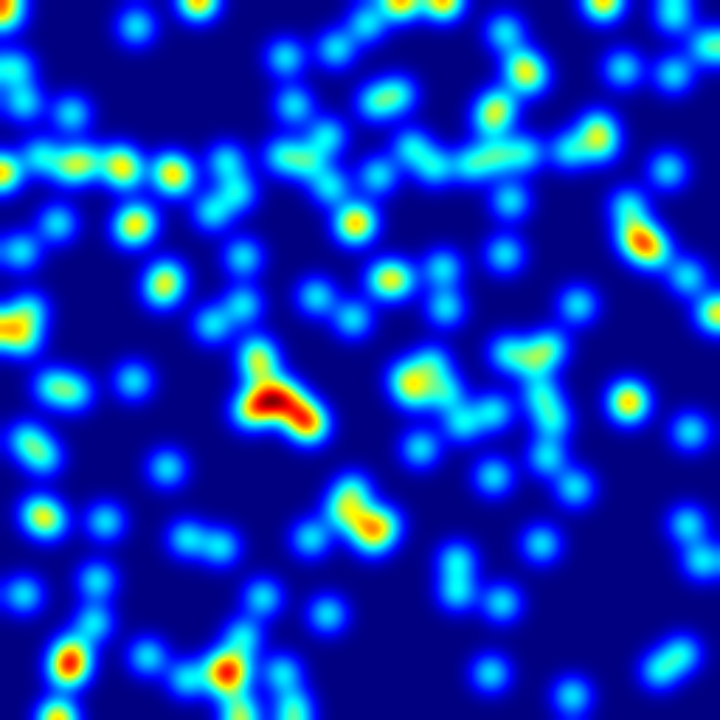

In [ ]:
image = cv2.imread("/content/blood_visualizations/Abhisri Das.png")
im1= cv2.resize(image,(50,50))
print(im1.shape)
cv2_imshow(im1)

Step 4: Train our own CNN model to Predict Glucose Voltage in any given blood [under microscope] image

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
image_folder = "blood_visualizations"
image_size = 128

In [ ]:
X = []
y = []

for i, row in df.iterrows():
    name = "".join(c for c in row["Name"] if c.isalnum() or c in (' ', '_')).rstrip()
    image_path = os.path.join(image_folder, f"{name}.png")
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        img = cv2.resize(img, (image_size, image_size))
        X.append(img)
        y.append(row["Voltage by NIR Glucometer"])

X = np.array(X) / 255.0  # Normalize images
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output a single voltage value
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [ ]:
model.fit(X_train, y_train, epochs=50, validation_split=0.1)

# Evaluate
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.2f}")

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 3.3802 - mae: 1.5628 - val_loss: 151.8038 - val_mae: 12.3189
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 140.4530 - mae: 11.6799 - val_loss: 0.0891 - val_mae: 0.2974
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.8656 - mae: 0.8129 - val_loss: 4.6423 - val_mae: 2.1529
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 5.4915 - mae: 2.1237 - val_loss: 2.8042 - val_mae: 1.6732
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 3.6978 - mae: 1.6662 - val_loss: 1.8227 - val_mae: 1.3487
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 2.7261 - mae: 1.3561 - val_loss: 1.1600 - val_mae: 1.0755
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 2.0600 - mae: 1.0952 - val_loss: 0.6089 - val_mae: 0.7780
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 1.5002 - mae: 0.8101 - val_loss: 0.1720 - val_mae: 0.4109
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 1.0311 - mae: 0.6

In [ ]:
model.save("blood_glucose_predictor.h5")

In [ ]:
import matplotlib.pyplot as plt

First Test image

In [ ]:
import tensorflow as tf

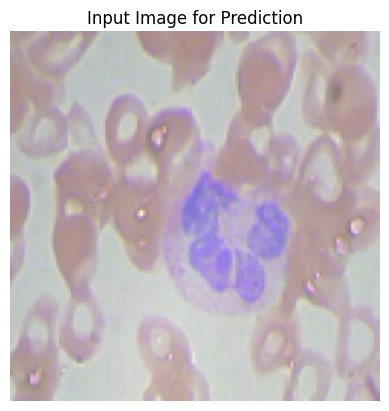

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
Predicted voltage (glucose proxy): 2.0829 V


In [ ]:
model = tf.keras.models.load_model("blood_glucose_predictor.h5")

# Load and preprocess your image
image_path = "BloodImage_00000.jpg"
image = cv2.imread(image_path)
resized = cv2.resize(image, (128, 128))  # Resize to model input shape
normalized = resized / 255.0  # Normalize pixel values
input_image = np.expand_dims(normalized, axis=0)  # Add batch dimension

# Display image
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.title("Input Image for Prediction")
plt.axis('off')
plt.show()

# Make prediction
prediction = model.predict(input_image)
print(f"Predicted voltage (glucose proxy): {prediction[0][0]:.4f} V")

In [ ]:
# Predicted voltage from the model
predicted_voltage = prediction[0][0]  # Example simulated value from model

# Conversion to glucose level (mg/dL)
a = 85
b = 30
glucose_level = a * predicted_voltage + b

# Determine glucose category
if glucose_level < 70:
    status = "Low (Hypoglycemia)"
elif 70 <= glucose_level <= 140:
    status = "Normal"
elif 140 < glucose_level <= 180:
    status = "Elevated (Pre-Diabetes)"
else:
    status = "High (Hyperglycemia / Diabetic Range)"

# Output statement
print(f"Predicted Voltage: {predicted_voltage:.2f} V")
print(f"Estimated Blood Glucose: {glucose_level:.2f} mg/dL")
print(f"Health Status: {status}")


Predicted Voltage: 2.08 V
Estimated Blood Glucose: 207.05 mg/dL
Health Status: High (Hyperglycemia / Diabetic Range)


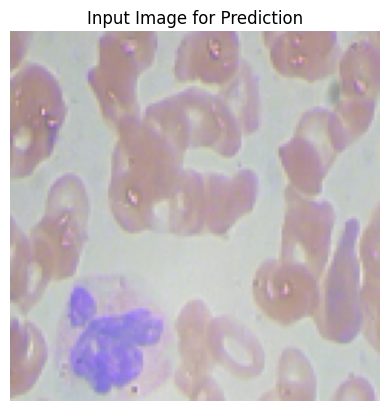

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
Predicted voltage (glucose proxy): 2.1149 V
Predicted Voltage: 2.11 V
Estimated Blood Glucose: 209.77 mg/dL
Health Status: High (Hyperglycemia / Diabetic Range)


In [ ]:
model = tf.keras.models.load_model("blood_glucose_predictor.h5")

# Load and preprocess your image
image_path = "BloodImage_00001.jpg"
image = cv2.imread(image_path)
resized = cv2.resize(image, (128, 128))  # Resize to model input shape
normalized = resized / 255.0  # Normalize pixel values
input_image = np.expand_dims(normalized, axis=0)  # Add batch dimension

# Display image
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.title("Input Image for Prediction")
plt.axis('off')
plt.show()

# Make prediction
prediction = model.predict(input_image)
print(f"Predicted voltage (glucose proxy): {prediction[0][0]:.4f} V")

# Predicted voltage from the model
predicted_voltage = prediction[0][0]  # Example simulated value from model

# Conversion to glucose level (mg/dL)
a = 85
b = 30
glucose_level = a * predicted_voltage + b

# Determine glucose category
if glucose_level < 70:
    status = "Low (Hypoglycemia)"
elif 70 <= glucose_level <= 140:
    status = "Normal"
elif 140 < glucose_level <= 180:
    status = "Elevated (Pre-Diabetes)"
else:
    status = "High (Hyperglycemia / Diabetic Range)"

# Output statement
print(f"Predicted Voltage: {predicted_voltage:.2f} V")
print(f"Estimated Blood Glucose: {glucose_level:.2f} mg/dL")
print(f"Health Status: {status}")


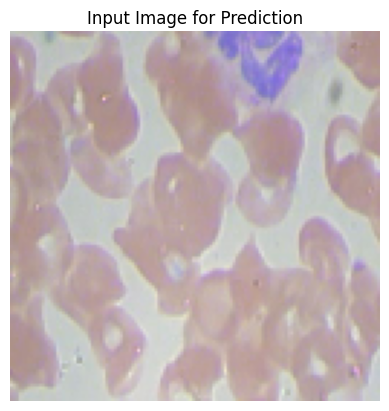

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Predicted voltage (glucose proxy): 2.1025 V
Predicted Voltage: 2.10 V
Estimated Blood Glucose: 208.71 mg/dL
Health Status: High (Hyperglycemia / Diabetic Range)


In [ ]:
model = tf.keras.models.load_model("blood_glucose_predictor.h5")

# Load and preprocess your image
image_path = "BloodImage_00002.jpg"
image = cv2.imread(image_path)
resized = cv2.resize(image, (128, 128))  # Resize to model input shape
normalized = resized / 255.0  # Normalize pixel values
input_image = np.expand_dims(normalized, axis=0)  # Add batch dimension

# Display image
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.title("Input Image for Prediction")
plt.axis('off')
plt.show()

# Make prediction
prediction = model.predict(input_image)
print(f"Predicted voltage (glucose proxy): {prediction[0][0]:.4f} V")

# Predicted voltage from the model
predicted_voltage = prediction[0][0]  # Example simulated value from model

# Conversion to glucose level (mg/dL)
a = 85
b = 30
glucose_level = a * predicted_voltage + b

# Determine glucose category
if glucose_level < 70:
    status = "Low (Hypoglycemia)"
elif 70 <= glucose_level <= 140:
    status = "Normal"
elif 140 < glucose_level <= 180:
    status = "Elevated (Pre-Diabetes)"
else:
    status = "High (Hyperglycemia / Diabetic Range)"

# Output statement
print(f"Predicted Voltage: {predicted_voltage:.2f} V")
print(f"Estimated Blood Glucose: {glucose_level:.2f} mg/dL")
print(f"Health Status: {status}")


Since this is yielding ambiguos results we attempt to couple our datasets


In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
!cd pytorch-CycleGAN-and-pix2pix

# Install dependencies
!pip install -r requirements.txt
!pip install torch torchvision


Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516 (from 1)
Receiving objects: 100% (2516/2516), 8.20 MiB | 17.42 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta

In [ ]:
import os
print(os.listdir())  # Should include 'train.py'


['.config', 'pytorch-CycleGAN-and-pix2pix', 'BloodImage_00000.jpg', 'data.csv', 'JPEGImages.zip', 'BloodImage_00002.jpg', 'BloodImage_00001.jpg', 'blood_glucose_predictor.h5', 'blood_visualizations', 'sample_data']


In [ ]:
%cd pytorch-CycleGAN-and-pix2pix
!ls  # to verify train.py exists
!python3 train.py


/content/pytorch-CycleGAN-and-pix2pix
CycleGAN.ipynb	docs		 LICENSE  pix2pix.ipynb     scripts   util
data		environment.yml  models   README.md	    test.py
datasets	imgs		 options  requirements.txt  train.py
Traceback (most recent call last):
  File "/content/pytorch-CycleGAN-and-pix2pix/train.py", line 22, in <module>
    from options.train_options import TrainOptions
  File "/content/pytorch-CycleGAN-and-pix2pix/options/train_options.py", line 1, in <module>
    from .base_options import BaseOptions
  File "/content/pytorch-CycleGAN-and-pix2pix/options/base_options.py", line 6, in <module>
    import data
  File "/content/pytorch-CycleGAN-and-pix2pix/data/__init__.py", line 15, in <module>
    from data.base_dataset import BaseDataset
  File "/content/pytorch-CycleGAN-and-pix2pix/data/base_dataset.py", line 9, in <module>
    import torchvision.transforms as transforms
  File "/usr/local/lib/python3.11/dist-packages/torchvision/__init__.py", line 10, in <module>
    from torchvision 

In [ ]:
import zipfile

In [ ]:
zip_path = '/content/trainA.zip'
extract_path = '/content/trainA/'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f'Files extracted to: {extract_path}')

Files extracted to: /content/trainA/


In [ ]:
import shutil
import random

def split_dataset(source_folder, test_folder, split_ratio=0.2):
    os.makedirs(test_folder, exist_ok=True)
    # Check if the source folder exists before attempting to list its files
    if os.path.exists(source_folder):
        files = os.listdir(source_folder)
        test_size = int(len(files) * split_ratio)
        test_files = random.sample(files, test_size)

        for file in test_files:
            shutil.move(os.path.join(source_folder, file), os.path.join(test_folder, file))
    else:
        print(f"Source folder '{source_folder}' not found.")

# Assuming your dataset is in the 'data' folder under 'pytorch-CycleGAN-and-pix2pix'
# Modify the paths as per your dataset structure
data_root = "/content/datasets"
split_dataset(os.path.join(data_root, 'trainA'), os.path.join(data_root, 'testA'))
split_dataset(os.path.join(data_root, 'trainB'), os.path.join(data_root, 'testB'))

In [ ]:
!pip install dominate

In [ ]:
print(os.path.isdir("/content/pytorch-CycleGAN-and-pix2pix"))
print(os.path.isdir("/content/pytorch-CycleGAN-and-pix2pix/datasets"))

True
True


In [ ]:
!pip install visdom


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 69.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sha256=dfcd2c0b640817ebe4d318b3206a32d20ced9491dbb0c257a2b9ca78f24595ab
  Stored in directory: /root/.cache/pip/wheels/fa/a4/bb/2be445c295d88a74f9c0a4232f04860ca489a5c7c57eb959d9
Successfully built visdom


In [ ]:
!nohup python -m visdom.server -port 8097 &

nohup: appending output to 'nohup.out'


In [ ]:
%cd /content/pytorch-CycleGAN-and-pix2pix


/content/pytorch-CycleGAN-and-pix2pix


In [ ]:
!python train.py --dataroot datasets --name blood_cyclegan --model cycle_gan --num_threads 2 --n_epochs 10 --n_epochs_decay 10


----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: datasets                      	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              

In [ ]:
!python test.py \
--dataroot ./datasets \
--name blood_cyclegan \
--model cycle_gan \
--phase test \
--no_dropout

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./datasets                    	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

In [ ]:
def glucose_category(voltage):
    if voltage < 2.5:
        return 0  # Low
    elif 2.5 <= voltage < 3.5:
        return 1  # Normal
    elif 3.5 <= voltage < 4.5:
        return 2  # Pre-Diabetic
    else:
        return 3  # Diabetic


In [ ]:
from glob import glob
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

def load_and_preprocess_image(path, label):
    img = cv2.imread(path)
    img = cv2.resize(img, (128, 128))

    # Convert to grayscale (simulating NIRS-style photo)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Normalize to [0, 1]
    norm = gray / 255.0

    # Expand dims to add channel back: (128,128,1)
    final_img = np.expand_dims(norm, axis=-1)
    return final_img, label

# Paths to generated images
image_dir = "./results/blood_cyclegan/test_latest/images"
all_images = sorted(glob(os.path.join(image_dir, "*_fake_B.png")))

# Example voltage labels matched by index (replace with real mapping)
# Let's assume you have `df` containing voltage per image
labels = [glucose_category(v) for v in df["Voltage by NIR Glucometer"].values]

# Preprocess all images
images = []
glucose_labels = []

for path, label in zip(all_images, labels):
    img, lbl = load_and_preprocess_image(path, label)
    images.append(img)
    glucose_labels.append(lbl)

X = np.array(images)
y = to_categorical(glucose_labels, num_classes=4)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 glucose categories
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=15, batch_size=16,
                    validation_data=(X_test, y_test))


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3167 - loss: 1.3606 - val_accuracy: 1.0000 - val_loss: 0.1330
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7833 - loss: 0.7001 - val_accuracy: 1.0000 - val_loss: 0.3020
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8042 - loss: 0.5129 - val_accuracy: 1.0000 - val_loss: 0.1240
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8375 - loss: 0.3613 - val_accuracy: 1.0000 - val_loss: 0.0374
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8792 - loss: 0.3008 - val_accuracy: 1.0000 - val_loss: 0.0435
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9125 - loss: 0.1611 - val_accuracy: 1.0000 - val_loss: 0.1010
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.1050 - val_accuracy: 1.0000 - val_loss: 0.1087
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 0.0862 - val_accuracy: 1.0000 - val_loss: 0.05

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0025
Test accuracy: 1.00


In [ ]:
model.save("glucose_cnn_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("glucose_cnn_model.h5")

# Path to generated images
test_image_dir = "./results/blood_cyclegan/test_latest/images"
image_paths = sorted([f for f in os.listdir(test_image_dir) if f.endswith("_fake_B.png")])

# Glucose category labels (edit if you want custom names)
category_names = ["Low", "Normal", "Pre-Diabetic", "Diabetic"]

def preprocess_for_prediction(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    norm = gray / 255.0
    final_img = np.expand_dims(norm, axis=-1)   # Shape: (128,128,1)
    final_img = np.expand_dims(final_img, axis=0)  # Shape: (1,128,128,1)
    return final_img

# Run prediction on each image
for filename in image_paths:
    full_path = os.path.join(test_image_dir, filename)
    image = preprocess_for_prediction(full_path)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    print(f"{filename} -> Predicted Glucose Category: {category_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
BloodImage_00003_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
BloodImage_00006_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
BloodImage_00009_fake_B.png -> Predicted Glucose Category: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
BloodImage_00011_fake_B.png -> Predicted Glucose Category: Pre-Diabetic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
BloodImage_00013_fake_B.png -> Predicted Glucose Category: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
BloodImage_00020_fake_B.png -> Predicted Glucose Category: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
BloodImage_00026_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
BloodImage_00030_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
BloodImage_00037_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
BloodImage_00038_fake_B.png -> Pre

TRAINING A NEW CYCLEGAN TO GENERATE MORE IMAGES

In [ ]:
!python train.py \
  --dataroot datasets \
  --name blood_cyclegan_B \
  --model cycle_gan \
  --num_threads 2 \
  --n_epochs 10 \
  --n_epochs_decay 10


----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: datasets                      	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              

In [ ]:
!python test.py \
  --dataroot datasets \
  --name blood_cyclegan_B \
  --model cycle_gan \
  --num_test 200 \
  --direction AtoB \
  --no_dropout


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: datasets                      	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("glucose_cnn_model.h5")

# Path to generated images
test_image_dir = "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/blood_cyclegan_B/web/images"
image_paths = sorted([f for f in os.listdir(test_image_dir) if f.endswith("_fake_B.png")])

# Glucose category labels (edit if you want custom names)
category_names = ["Low", "Normal", "Pre-Diabetic", "Diabetic"]

def preprocess_for_prediction(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    norm = gray / 255.0
    final_img = np.expand_dims(norm, axis=-1)   # Shape: (128,128,1)
    final_img = np.expand_dims(final_img, axis=0)  # Shape: (1,128,128,1)
    return final_img

# Run prediction on each image
for filename in image_paths:
    full_path = os.path.join(test_image_dir, filename)
    image = preprocess_for_prediction(full_path)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    print(f"{filename} -> Predicted Glucose Category: {category_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
epoch002_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
epoch003_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
epoch005_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch006_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch007_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
epoch009_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
epoch010_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
epoch011_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
epoch013_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
epoch014_fake_B.png -> Predicted Glucose Category: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
epoch016_fake_B.png -> Predicte

In [ ]:
zip_path = "/content/JPEGImages.zip"
unzip_dir = "/content/JPEGImages"

# Unzip if not already done
if not os.path.exists(unzip_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("glucose_cnn_model.h5")

# Path to generated images
test_image_dir = "/content/JPEGImages/JPEGImages"
image_paths = sorted([f for f in os.listdir(test_image_dir) if f.endswith("_fake_B.png")])

# Glucose category labels (edit if you want custom names)
category_names = ["Low", "Normal", "Pre-Diabetic", "Diabetic"]

def preprocess_for_prediction(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    norm = gray / 255.0
    final_img = np.expand_dims(norm, axis=-1)   # Shape: (128,128,1)
    final_img = np.expand_dims(final_img, axis=0)  # Shape: (1,128,128,1)
    return final_img

# Run prediction on each image
for filename in image_paths:
    full_path = os.path.join(test_image_dir, filename)d
    image = preprocess_for_prediction(full_path)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    print(f"{filename} -> Predicted Glucose Category: {category_names[predicted_class]}")

In [ ]:
!pip install fitz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
!pip install PyMuPDF
!pip install tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 106.8 MB/s eta 0:00:00


In [ ]:
import fitz  # PyMuPDF, for PDF redaction

# File paths
input_pdf_path = "/content/sampleagreement.pdf"
output_pdf_path = "/content/sampleagreement1.pdf"

# Open the original PDF
doc = fitz.open(input_pdf_path)

# Define target company name (case-insensitive)
company_name = "kitara garages private limited"

# Perform redactions on each page
for page in doc:
    # Search for company name occurrences (flag 1 = ignore case)
    text_instances = page.search_for(company_name, flags=1)
    for inst in text_instances:
        # Redact the exact company name
        page.add_redact_annot(inst, fill=(0, 0, 0))
        # Also redact an area below to cover the address if it's directly under the name
        below = fitz.Rect(inst.x0, inst.y1, inst.x1 + 200, inst.y1 + 80)
        page.add_redact_annot(below, fill=(0, 0, 0))
    # Apply redactions on this page
    page.apply_redactions()

# Save the updated PDF
doc.save(output_pdf_path)

print(f"Redacted PDF saved to: {output_pdf_path}")



Redacted PDF saved to: /content/sampleagreement1.pdf
